In [1]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [2]:
# Read Google Sheets file with Honkai Star Rail Enemy Weaknesses

!pip install --upgrade -q gspread

import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

worksheet = gc.open('Honkai Star Rail Enemy Weaknesses').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)

In [3]:
# Look at the imported dataframe
df.head()

,0,1,2,3,4,5,6,7,8
0,Enemy,Elite,Physical,Fire,Ice,Lightning,Wind,Quantum,Imaginary
1,Disciples of Sanctus Medicus - Internal Alchemist,No,Yes,No,No,No,No,No,Yes
2,Cloud Knights Patroller,No,No,Yes,No,No,Yes,No,Yes
3,Flamespawn,No,Yes,No,Yes,No,No,No,No
4,Frostspawn,No,No,Yes,No,No,Yes,No,No


In [4]:
new_header = df.iloc[0] # Grab the first row for the header
df = df[1:] # Take the data less the header row
df.columns = new_header # Set the header row as the df header
df.head()

,Enemy,Elite,Physical,Fire,Ice,Lightning,Wind,Quantum,Imaginary
1,Disciples of Sanctus Medicus - Internal Alchemist,No,Yes,No,No,No,No,No,Yes
2,Cloud Knights Patroller,No,No,Yes,No,No,Yes,No,Yes
3,Flamespawn,No,Yes,No,Yes,No,No,No,No
4,Frostspawn,No,No,Yes,No,No,Yes,No,No
5,Thunderspawn,No,Yes,No,No,No,Yes,No,No


In [5]:
# Switch to a binary encoding
df.replace(('Yes', 'No'), (1, 0), inplace=True)
df.head()

<ipython-input-5-4b8fe21ced28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(('Yes', 'No'), (1, 0), inplace=True)


,Enemy,Elite,Physical,Fire,Ice,Lightning,Wind,Quantum,Imaginary
1,Disciples of Sanctus Medicus - Internal Alchemist,0,1,0,0,0,0,0,1
2,Cloud Knights Patroller,0,0,1,0,0,1,0,1
3,Flamespawn,0,1,0,1,0,0,0,0
4,Frostspawn,0,0,1,0,0,1,0,0
5,Thunderspawn,0,1,0,0,0,1,0,0


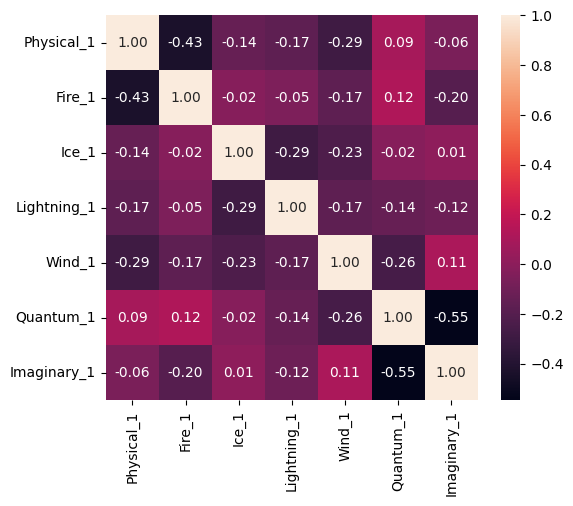

In [6]:
# Overall correlation heatmap
df_overall = df.drop(columns=['Enemy', 'Elite'])
enc = OneHotEncoder(drop='if_binary')
arr = enc.fit_transform(df_overall).toarray()
one_hot_all = pd.DataFrame(arr, columns=enc.get_feature_names_out(df_overall.columns))
plt.subplots(figsize=(6,5))
sns.heatmap(one_hot_all.corr(),xticklabels=1,yticklabels=1,annot=True,fmt='.2f');

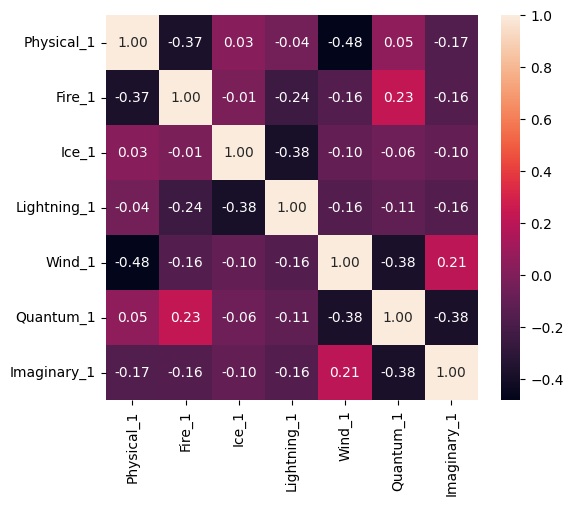

In [7]:
# Common enemies correlation heatmap
df_common = df[df['Elite'] == 0].drop(columns=['Enemy', 'Elite'])
enc = OneHotEncoder(drop='if_binary')
arr = enc.fit_transform(df_common).toarray()
one_hot_all = pd.DataFrame(arr, columns=enc.get_feature_names_out(df_common.columns))
plt.subplots(figsize=(6,5))
sns.heatmap(one_hot_all.corr(),xticklabels=1,yticklabels=1,annot=True,fmt='.2f');

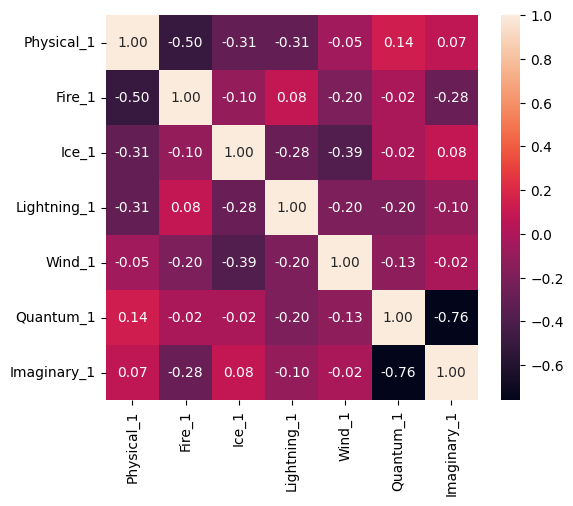

In [8]:
# Elite enemies correlation heatmap
df_elite = df[df['Elite'] == 1].drop(columns=['Enemy', 'Elite'])
enc = OneHotEncoder(drop='if_binary')
arr = enc.fit_transform(df_elite).toarray()
one_hot_all = pd.DataFrame(arr, columns=enc.get_feature_names_out(df_elite.columns))
plt.subplots(figsize=(6,5))
sns.heatmap(one_hot_all.corr(),xticklabels=1,yticklabels=1,annot=True,fmt='.2f');

In [9]:
# Define (generalized) correlation matrix
def corr_matrix(data, func):
    arr = np.empty((len(data.T),len(data.T)))
    for i in range(len(data.T)):
        for j in range(len(data.T)):
            arr[i][j] = func(data.iloc[:,i], data.iloc[:,j])
    df = pd.DataFrame(data=arr)
    df.index = data.columns
    df.columns = data.columns
    return df

In [10]:
# Define conditional entropy
def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * np.log(p_y / p_xy)
    return entropy

In [11]:
# Define Theil's U which is a directional measure of correlation magnitude based on conditional entropy
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

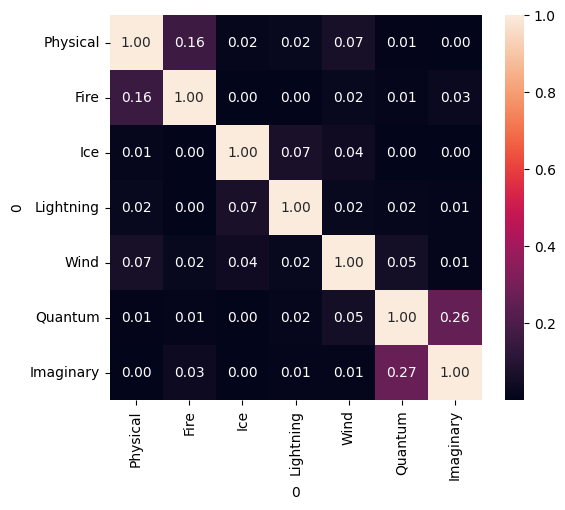

In [12]:
# Show a seaborn heatmap of correlation magnitudes in df_overall using Theil's U.
# Theil's U, U(x,y), conditions on y, which in our case would be the column, but
# a transition matrix format ($p_{i,j}$) is more intuitive and conditions on i,
# the row, so we take the transpose of the correlation matrix determined by Theil's U.
# Hint: call corr_matrix on the dataframe and pass that into `sns.heatmap`
plt.subplots(figsize=(6,5))
sns.heatmap(corr_matrix(data=df_overall,func=theils_u).T,annot=True,fmt='.2f');

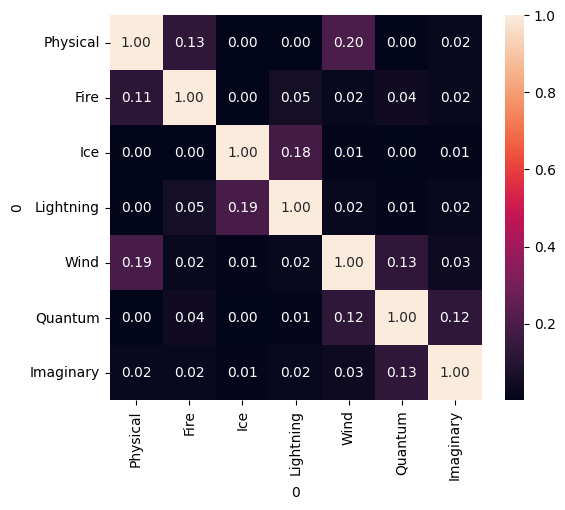

In [13]:
# Show a seaborn heatmap of correlation magnitudes in df_common using Theil's U.
# Theil's U, U(x,y), conditions on y, which in our case would be the column, but
# a transition matrix format ($p_{i,j}$) is more intuitive and conditions on i,
# the row, so we take the transpose of the correlation matrix determined by Theil's U.
# Hint: call corr_matrix on the dataframe and pass that into `sns.heatmap`
plt.subplots(figsize=(6,5))
sns.heatmap(corr_matrix(data=df_common,func=theils_u).T,annot=True,fmt='.2f');

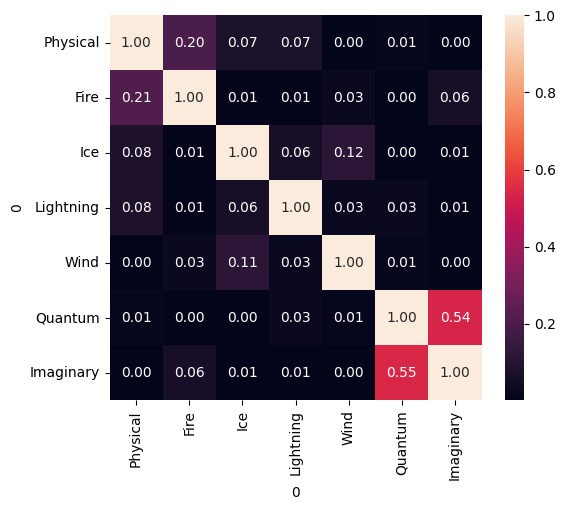

In [14]:
# Show a seaborn heatmap of correlation magnitudes in df_elite using Theil's U.
# Theil's U, U(x,y), conditions on y, which in our case would be the column, but
# a transition matrix format ($p_{i,j}$) is more intuitive and conditions on i,
# the row, so we take the transpose of the correlation matrix determined by Theil's U.
# Hint: call corr_matrix on the dataframe and pass that into `sns.heatmap`
plt.subplots(figsize=(6,5))
sns.heatmap(corr_matrix(data=df_elite,func=theils_u).T,annot=True,fmt='.2f');